<a href="https://colab.research.google.com/github/lewis-m/erk-kinetics-tda/blob/master/NicePlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Prerequesite installations
#Run once everytime runtime is restarted

import numpy as np
import cython

!pip install pystan
!pip install Ripser

import pystan as ps
from ripser import ripser
from persim import plot_diagrams, bottleneck, images

     |████████████████████████████████| 81kB 5.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/95/6f/54/972a0889246bc3b1b47d769021bd61bb1d42153cdb58aa7fd3
Successfully built Ripser


In [2]:
#Upload file/data
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving phosphomimeticMEKdata.xlsx to phosphomimeticMEKdata.xlsx
Saving FirstData.xlsx to FirstData.xlsx


In [0]:
#Import empirical data
import numpy as np
import pandas as pd

xlsx = pd.ExcelFile('FirstData.xlsx')
df = pd.read_excel(xlsx, 'Wild Type')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

wild_type = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'Y130C')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

y130c = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'F53S')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

f53s = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'E203K')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

e203k = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])


#put all data into one data frame
bayes_td = np.array([wild_type, y130c, f53s, e203k])

In [0]:
#Import in-vivo data

xlsx = pd.ExcelFile('phosphomimeticMEKdata.xlsx')
df = pd.read_excel(xlsx, 'P-MEKWT_KRTA')

t1 = df.iloc[3:10, 1:4]
t2 = df.iloc[13:20, 1:4]
t3 = df.iloc[23:30, 1:4]
t4 = df.iloc[33:40, 1:4]
t5 = df.iloc[43:50, 1:4]

invivo1 = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'SSDD')

t1 = df.iloc[3:10, 1:4]
t2 = df.iloc[13:20, 1:4]
t3 = df.iloc[24:31, 1:4]
t4 = df.iloc[35:42, 1:4]
t5 = df.iloc[46:53, 1:4]
t6 = df.iloc[57:64, 1:4]


invivo2 = np.array([t1.values, t2.values, t3.values, t4.values, t5.values, t6.values])
#print(invivo2)

bayes_td = np.array([wild_type, y130c, f53s, e203k, invivo1, invivo2])

In [0]:
def stan_model_yd(yeast_data, alt_ts = False):

  time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]
  
  if alt_ts:
    time_stamps = [0.5, 2, 3.25, 5, 10, 20, 40]

  yeast_code = """
  data {
      int<lower=0> T; // number of trials
      int<lower=0> TS; // number of timesteps
      vector[TS] ts; // time values
      real S0[TS,T]; // param S0
      real S1[TS,T]; // param S1
      real S2[TS,T]; // param S2
  }
  parameters {
      real P1;
      real P2;
      real Pi;
      real sigma1;
      //real sigma2;
      //real sigma3;
  }

  model {
      P1 ~ uniform(0,10);
      P2 ~ uniform(0,10);
      Pi ~ uniform(0,10);
      
      sigma1 ~ uniform(0,10);
      //sigma2 ~ uniform(0,10);
      //sigma3 ~ uniform(0,10);   

      for(i in 1:TS){
        real s0 = exp(-P1*ts[i]);
        real s1 = P1*(1-Pi)/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i]));
        real s2 = P1*Pi/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i])) + P2/(P1-P2)*(exp(-P1*ts[i]) - 1) + P1/(P1-P2)*(1-exp(-P2*ts[i]));
        
        S0[i, :] ~ normal(s0, sigma1);
        S1[i, :] ~ normal(s1, sigma1);
        S2[i, :] ~ normal(s2, sigma1);
      }
  }
  """

  S0 = np.stack([yeast_data[:, 0, 0], yeast_data[:, 1, 0], yeast_data[:, 2, 0], yeast_data[:, 3, 0], yeast_data[:, 4, 0], yeast_data[:, 5, 0], yeast_data[:, 6, 0]])
  S1 = np.stack([yeast_data[:, 0, 1], yeast_data[:, 1, 1], yeast_data[:, 2, 1], yeast_data[:, 3, 1], yeast_data[:, 4, 1], yeast_data[:, 5, 1], yeast_data[:, 6, 1]])
  S2 = np.stack([yeast_data[:, 0, 2], yeast_data[:, 1, 2], yeast_data[:, 2, 2], yeast_data[:, 3, 2], yeast_data[:, 4, 2], yeast_data[:, 5, 2], yeast_data[:, 6, 2]])

  S0 = np.array(S0, dtype = float)
  S1 = np.array(S1, dtype = float)
  S2 = np.array(S2, dtype = float)

  S0 = S0/5
  S1 = S1/5
  S2 = S2/5
  
  dimensions = yeast_data.shape

  yeast_dat = {'T': dimensions[0],
               'TS': dimensions[1],
               'ts': time_stamps,
               'S0': S0,
               'S1': S1,
               'S2': S2}

  sm = ps.StanModel(model_code=yeast_code)
  fit = sm.sampling(data=yeast_dat, iter=1000, chains=4)
  
  return fit


#Calculate the bottleneck distance between two (multi-dimensional) PDs
#and the three analytical ODE solutions

def bottleneck_distance(dgm1, dgm2):
  dim = len(dgm1)
  
  distance = []
  
  for i in range(dim):
    #dgm1_this_dim = dionysus.Diagram(dgm1[i])
    #dgm2_this_dim = dionysus.Diagram(dgm2[i])

    distance.append(bottleneck(dgm1[i], dgm2[i]))
    
  return distance



def s0_fun(t, param):
  return np.exp(-param[0]*t)

def s1_fun(t, param):
  return param[0]*(1-param[2])/(param[0]-param[1])*(np.exp(-param[1]*t) - np.exp(-param[0]*t))

def s2_fun(t, param):
  return param[0]*param[2]/(param[0]-param[1])*(np.exp(-param[1]*t) - np.exp(-param[0]*t)) + param[1]/(param[0]-param[1])*(np.exp(-param[0]*t) - 1) + param[0]/(param[0]-param[1])*(1-np.exp(-param[1]*t))



In [6]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

y_type = ['WildType', 'Y130C', 'F53S', 'E203K', 'nothing', "SSDD"]
persistence_ds = []

total_bayes_data = []

for i in [0, 1, 2, 3, 5]:
  if i == 5:
    fit = stan_model_yd(bayes_td[i], alt_ts = True)
  else:
    fit = stan_model_yd(bayes_td[i])
  
  #print('\n Bayesian model for yeast type %r:' % y_type[i])
  print(fit)

  posterior = fit.extract()
  bayes_data = np.stack([posterior['P1'], posterior['P2'], posterior['Pi']])
  bayes_data = np.swapaxes(bayes_data, 0, 1)
  total_bayes_data.append(bayes_data)

  """
  bayes_pd = ripser(bayes_data[0:800], maxdim = 2)
  persistence_ds.append(bayes_pd['dgms'])
  
  plt.title(y_type[i])
  plt.subplot(1, 2, 1)
  plot_diagrams(bayes_pd['dgms'], title='Bayesian')

  bs_pd = ripser(bs_data[i][0:800], maxdim = 2)
  
  plt.subplot(1, 2, 2)
  plot_diagrams(bs_pd['dgms'], title='Bootstrapped')
  plt.show()
  
  exp_file = '%s_PD.png' % y_type[i]
  #plt.savefig(exp_file)
  
  print('Bottleneck distance:')
  print(bottleneck_distance(bs_pd['dgms'], bayes_pd['dgms']))
  
  
  fig = plt.figure()
  
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(posterior['P1'], posterior['P2'], posterior['Pi'], c = 'b', marker='o', label='Bayesian')
  ax.scatter(bs_data[i][:, 0], bs_data[i][:, 1], bs_data[i][:, 2], c = 'r', marker='o', label='BS')
  ax.legend(loc='upper left')
  ax.set_xlabel('P1')
  ax.set_ylabel('P2')
  ax.set_zlabel('Pi')
  #ax.title(str(y_type[i]))

  plt.show()
  exp_file = '%s_Scatter.png' % y_type[i]
  #plt.savefig(exp_file)
  """
  
for i in range(len(persistence_ds) - 1):
    for j in range(i + 1, len(persistence_ds)):
      print('Bottleneck distance of Bayes PDs of %s and %s:' % (y_type[i], y_type[j]))
      print(bottleneck_distance(persistence_ds[i], persistence_ds[j]))
      print('')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.29  5.5e-4   0.02   0.26   0.28   0.29    0.3   0.32    863    1.0
P2       0.19  1.6e-3   0.04   0.12   0.16   0.18   0.21   0.29    682    1.0
Pi       0.31  2.8e-3   0.07   0.14   0.26   0.31   0.36   0.43    730    1.0
sigma1    0.1  1.9e-4 7.3e-3   0.09    0.1    0.1   0.11   0.12   1517    1.0
lp__   185.73    0.05   1.43 182.09 184.98 186.04 186.82 187.58    799    1.0

Samples were drawn using NUTS at Sun May 19 11:19:09 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.36  3.7e-4   0.01   0.34   0.35   0.36   0.37   0.39   1416    1.0
P2       0.16  6.4e-4   0.02   0.13   0.15   0.16   0.17    0.2    750   1.01
Pi        0.3  1.3e-3   0.04   0.23   0.28   0.31   0.33   0.37    824   1.01
sigma1   0.07  1.2e-4 5.1e-3   0.06   0.07   0.07   0.08   0.08   1902    1.0
lp__   224.09    0.05    1.4 220.67  223.4 224.43 225.09 225.88    913   1.01

Samples were drawn using NUTS at Sun May 19 11:20:24 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.41  5.9e-4   0.02   0.37   0.39   0.41   0.42   0.46   1431    1.0
P2       0.16  8.3e-4   0.02   0.12   0.15   0.16   0.18   0.22    834    1.0
Pi       0.28  1.7e-3   0.05   0.17   0.25   0.28   0.32   0.37    831    1.0
sigma1   0.09  1.4e-4 6.4e-3   0.08   0.09   0.09   0.09    0.1   2027    1.0
lp__   200.47    0.05   1.44 196.86 199.76 200.78  201.5 202.28    920    1.0

Samples were drawn using NUTS at Sun May 19 11:21:39 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.63  1.3e-3   0.05   0.55    0.6   0.63   0.66   0.74   1344    1.0
P2        0.1  6.1e-4   0.02   0.06   0.08   0.09   0.11   0.14   1068    1.0
Pi       0.55  1.1e-3   0.04   0.48   0.53   0.55   0.58   0.62   1083    1.0
sigma1   0.11  1.9e-4 7.7e-3   0.09    0.1    0.1   0.11   0.12   1702    1.0
lp__   184.39    0.06   1.58 180.42 183.69 184.76 185.54 186.28    805   1.01

Samples were drawn using NUTS at Sun May 19 11:22:55 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 

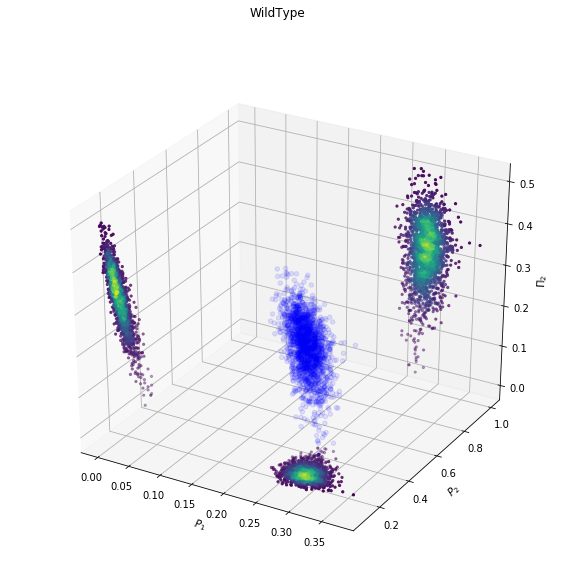

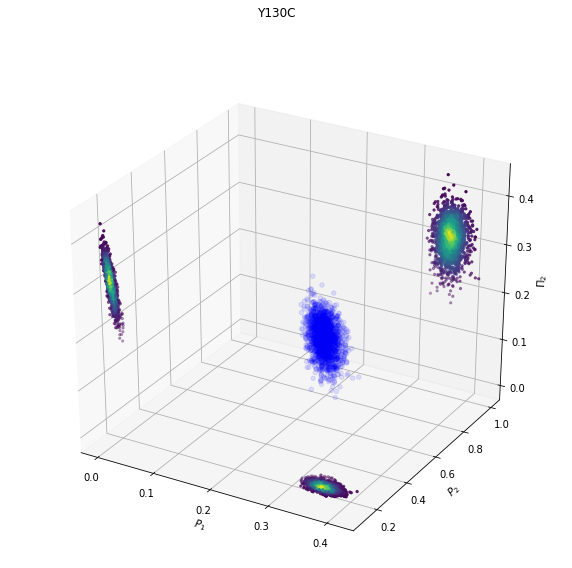

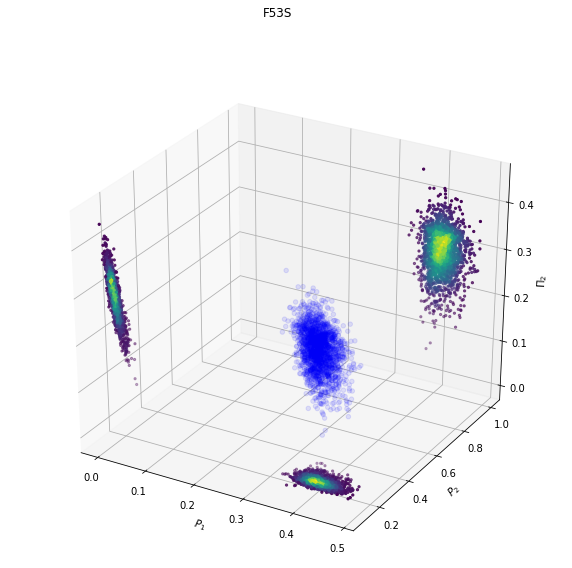

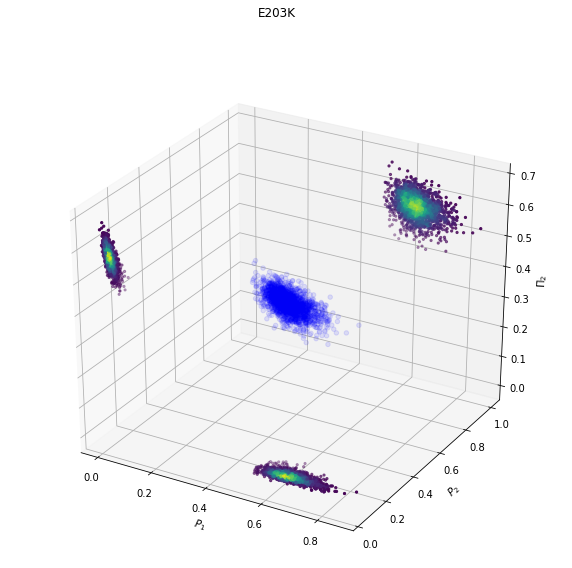

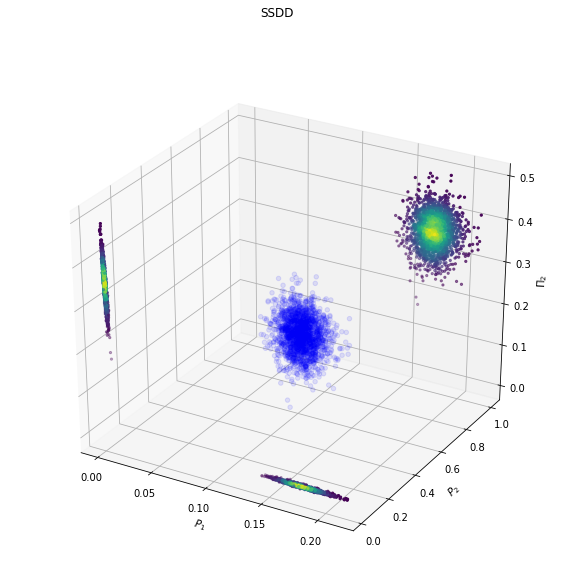

In [55]:
import scipy.stats as st
import mpl_scatter_density
from matplotlib import rc
#matplotlib.rcParams['legend.fontsize'] = 10


def open_ball(a, x, r):
  ball = []
  for y in a:
    if np.linalg.norm(x - y) < r:
      ball.append(y)
  return ball

y_type = ['WildType', 'Y130C', 'F53S', 'E203K', "SSDD"]

for i in range(len(total_bayes_data)):
  bayes_data = total_bayes_data[i]
  
  fig = plt.figure(figsize=(10,9))
  fig.suptitle(y_type[i])
  
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(bayes_data[:,0], bayes_data[:,1], bayes_data[:,2], c = 'b', marker='o', label='Bayesian', alpha=0.1)
  
  x_marg = []
  y_marg = []
  z_marg = []
  
  for x, y, z in bayes_data:
    x_marg.append([0, y, z])
    y_marg.append([x, 1, z])
    z_marg.append([x, y, 0])
    
  x_marg = np.array(x_marg)
  y_marg = np.array(y_marg)
  z_marg = np.array(z_marg)
  
  s_x = [len(open_ball(x_marg, x, 0.01)) for x in x_marg]
  ax.scatter(x_marg[:,0], x_marg[:,1], x_marg[:,2], c=s_x, marker='.')
  
  s_y = [len(open_ball(y_marg, x, 0.01)) for x in y_marg]
  ax.scatter(y_marg[:,0], y_marg[:,1], y_marg[:,2], c=s_y, marker='.')

  s_z = [len(open_ball(z_marg, x, 0.01)) for x in z_marg]
  ax.scatter(z_marg[:,0], z_marg[:,1], z_marg[:,2], c=s_z, marker='.')
  
  ax.set_xlabel(r'$P_1$')
  ax.set_ylabel(r'$P_2$')
  ax.set_zlabel(r'$\Pi_2$')
  #ax.set_ylim([0, 1])
  #ax.set_xlim([0, 1])
  #ax.set_zlim([0, 1])
  
  plt.show()


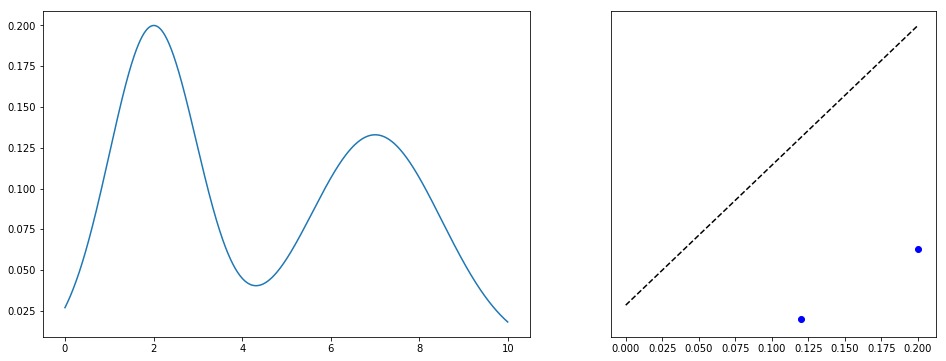

In [85]:
import scipy as sp
from matplotlib import gridspec


y_func = lambda x: 0.5*sp.stats.norm.pdf(x, 2, 1) + 0.5*sp.stats.norm.pdf(x, 7, 1.5)

x = np.arange(0, 10, 0.01)
y = [y_func(xx) for xx in x]

fig = plt.figure(figsize=(16, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x, y)

x = np.arange(0, 0.21, 0.01)

### Look up how to insert infty line using persim github

ax1 = plt.subplot(gs[1])
ax1.set_yticklabels([])
ax1.get_yaxis().set_visible(False)
ax1.plot(x, x, linestyle = '--', c='k')
ax1.scatter(x=[0.2, 0.12], y=[0.04, -0.01], c='b', marker='o')